In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import re 

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from scipy.spatial.distance import pdist
from wordcloud import WordCloud

!pip -q install wordcloud


In [120]:
df = pd.read_csv("Tweets 2.csv")
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [121]:
df = df[["text", "airline_sentiment", "airline", "negativereason"]].dropna(subset=["text","airline_sentiment"])
df.head()



,text,airline_sentiment,airline,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,Virgin America,NaN
1,@VirginAmerica plus you've added commercials t...,positive,Virgin America,NaN
2,@VirginAmerica I didn't today... Must mean I n...,neutral,Virgin America,NaN
3,@VirginAmerica it's really aggressive to blast...,negative,Virgin America,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,negative,Virgin America,Can't Tell


In [122]:
keep = {"not", "no", "nor"}
stopwords = ENGLISH_STOP_WORDS - keep

def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|@\w+|[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return " ".join(w for w in s.split()
                    if w in keep or (w not in stopwords and len(w) >= 3))

df["clean_text2b"] = df["text"].apply(clean_text)

df[["text", "clean_text2b"]].head()


,text,clean_text2b
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didn today mean need trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


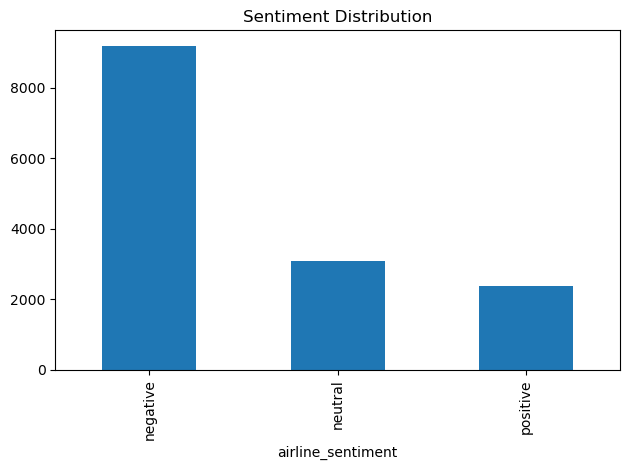

In [123]:
df["airline_sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()



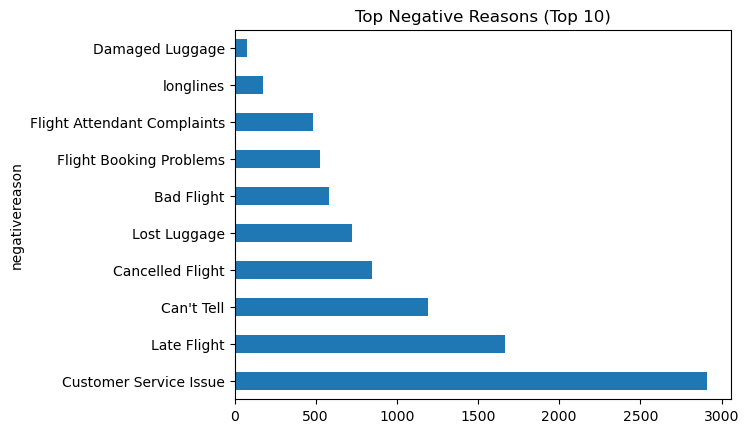

In [124]:
df[df["airline_sentiment"]=="negative"]["negativereason"].dropna().value_counts().head(10).plot(kind="barh")
plt.title("Top Negative Reasons (Top 10)")
plt.savefig("top_negative_reasons.png")
plt.show()


In [125]:
X = df["clean_text2b"]
y = df["airline_sentiment"]
cv = StratifiedKFold(10, shuffle=True, random_state=42)

svm = Pipeline([("t", TfidfVectorizer()), ("m", LinearSVC(C=0.5))])
p = cross_val_predict(svm, X, y, cv=cv)

print("Accuracy:", round(accuracy_score(y, p)*100, 2))
print("Macro-F1:", round(f1_score(y, p, average="macro"), 4))

Accuracy: 78.64
Macro-F1: 0.713


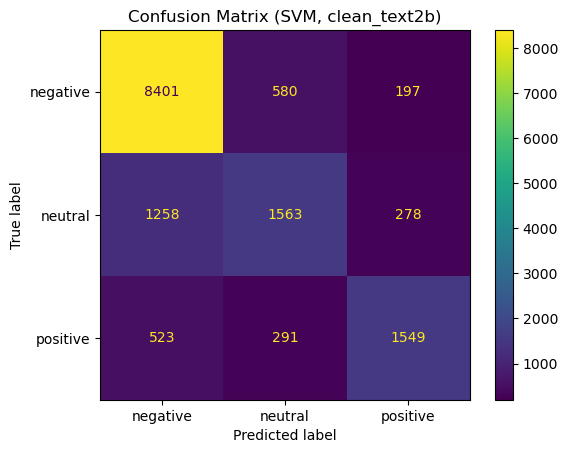

In [126]:
ConfusionMatrixDisplay.from_predictions(y, p)
plt.title("Confusion Matrix (SVM, clean_text2b)")
plt.savefig("confusion_matrix_final.png")
plt.show()


In [127]:
svm = Pipeline([("tfidf", TfidfVectorizer()), ("svm", LinearSVC(C=0.5))])
p_svm = cross_val_predict(svm, X, y, cv=cv)

print("SVM Accuracy:", round(accuracy_score(y, p_svm)*100, 2))
print("SVM Macro-F1:", round(f1_score(y, p_svm, average="macro"), 4))


SVM Accuracy: 78.64
SVM Macro-F1: 0.713


In [128]:
nb = Pipeline([("tfidf", TfidfVectorizer()), ("svm", MultinomialNB(alpha=0.1))])
p_nb = cross_val_predict(nb, X, y, cv=cv)

print("NB Accuracy:", round(accuracy_score(y, p_nb)*100, 2))
print("NB Macro-F1:", round(f1_score(y, p_nb, average="macro"), 4))


NB Accuracy: 75.09
NB Macro-F1: 0.6334


In [129]:
vote = VotingClassifier([("nb", nb), ("svm", svm)], voting="hard", weights=[1,2])
p_vote = cross_val_predict(vote, X, y, cv=cv)

print("VOTE Accuracy (%):", round(accuracy_score(y, p_vote)*100, 2))
print("VOTE Macro-F1:", round(f1_score(y, p_vote, average="macro"), 4))


VOTE Accuracy (%): 78.64
VOTE Macro-F1: 0.713


In [130]:
df.to_csv("tweets_clean_text2b.csv", index=False)



In [131]:
results = pd.DataFrame([
    ["SVM (C=0.5)",  accuracy_score(y, p_svm)*100,  f1_score(y, p_svm, average="macro")],
    ["NB (a=0.1)",   accuracy_score(y, p_nb)*100,   f1_score(y, p_nb, average="macro")],
    ["VOTE (1:2)",   accuracy_score(y, p_vote)*100, f1_score(y, p_vote, average="macro")],
], columns=["Model","Accuracy (%)","Macro-F1"])

results["Accuracy (%)"] = results["Accuracy (%)"].round(2)
results["Macro-F1"] = results["Macro-F1"].round(4)

results.to_csv("final_results_table.csv", index=False)
results



,Model,Accuracy (%),Macro-F1
0,SVM (C=0.5),78.64,0.7130
1,NB (a=0.1),75.09,0.6334
2,VOTE (1:2),78.64,0.7130


In [132]:
tags = df["text"].str.findall(r"#\w+").explode().dropna().str.lower()
tag_text = " ".join(tags)


In [149]:

wc = WordCloud(background_color="white").generate(tag_text)


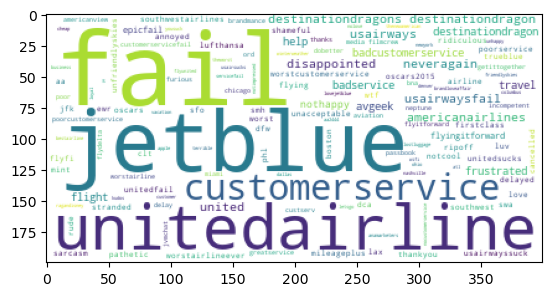

In [150]:
img = wc.to_image()

plt.imshow(img)
plt.savefig("hashtag_wordcloud.png")
plt.show()


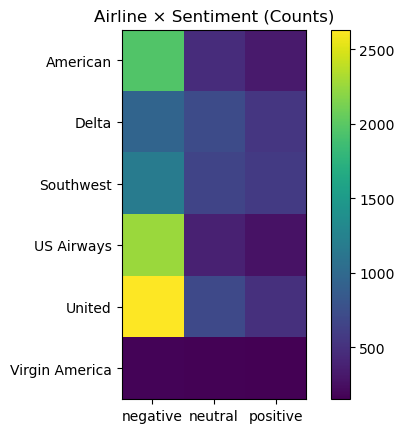

In [135]:
tab = pd.crosstab(df["airline"], df["airline_sentiment"])

plt.imshow(tab.values)
plt.xticks(range(len(tab.columns)), tab.columns)
plt.yticks(range(len(tab.index)), tab.index)
plt.title("Airline × Sentiment (Counts)")
plt.colorbar()
plt.savefig("heatmap_airline_sentiment.png")
plt.show()



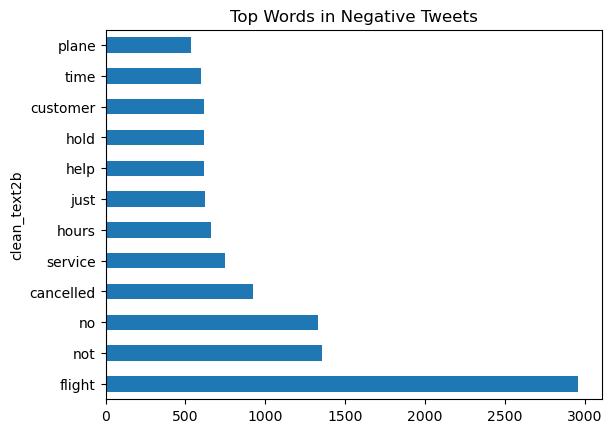

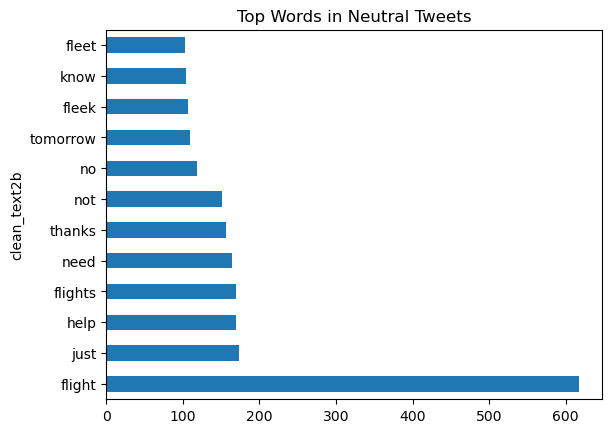

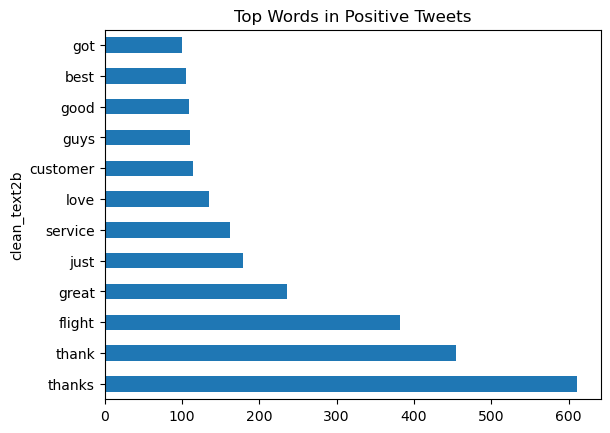

In [136]:
w = df[df["airline_sentiment"] == "negative"]["clean_text2b"]
w = w.str.split().explode()

w.value_counts().head(12).plot(kind="barh")
plt.title("Top Words in Negative Tweets")
plt.savefig("top_words_negative.png")
plt.show()

w = df[df["airline_sentiment"] == "neutral"]["clean_text2b"]
w = w.str.split().explode()

w.value_counts().head(12).plot(kind="barh")
plt.title("Top Words in Neutral Tweets")
plt.savefig("top_words_neutral.png")
plt.show()

w = df[df["airline_sentiment"] == "positive"]["clean_text2b"]
w = w.str.split().explode()

w.value_counts().head(12).plot(kind="barh")
plt.title("Top Words in Positive Tweets")
plt.savefig("top_words_positive.png")
plt.show()



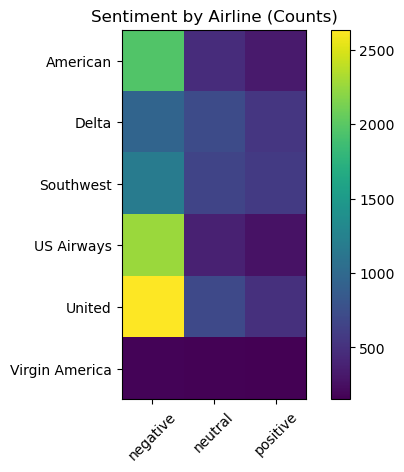

In [137]:


tab = pd.crosstab(df["airline"], df["airline_sentiment"])
plt.imshow(tab.values)
plt.xticks(range(len(tab.columns)), tab.columns, rotation=45)
plt.yticks(range(len(tab.index)), tab.index)
plt.title("Sentiment by Airline (Counts)")
plt.colorbar()
plt.savefig("heatmap_airline_sentiment.png")
plt.show()


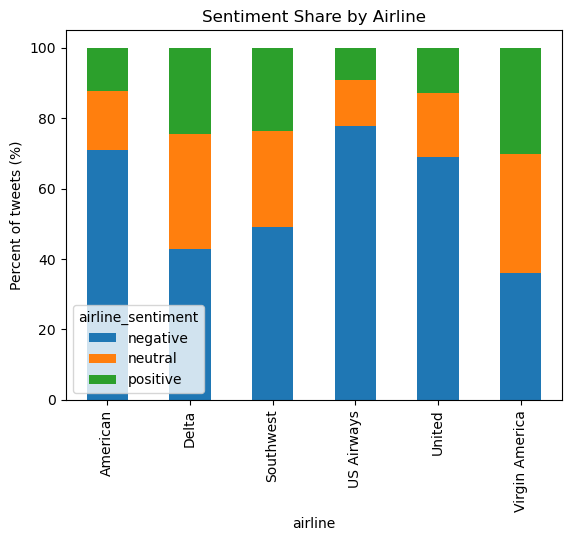

In [138]:
pct = pd.crosstab(df["airline"], df["airline_sentiment"], normalize="index") * 100

pct.plot(kind="bar", stacked=True)
plt.ylabel("Percent of tweets (%)")
plt.title("Sentiment Share by Airline")
plt.savefig("sentiment_share_by_airline.png")
plt.show()


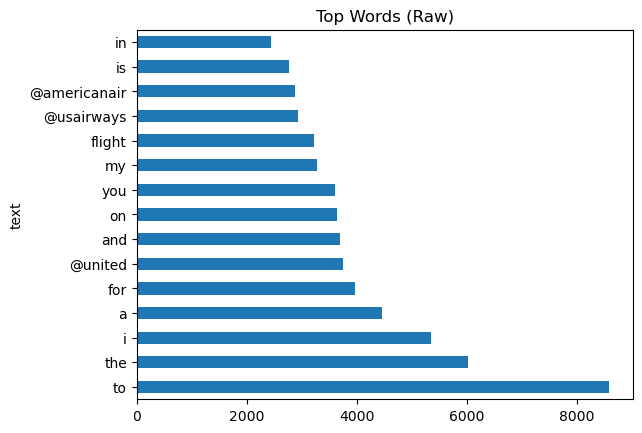

In [139]:

raw_words = df["text"].str.lower().str.split().explode()
raw_words.value_counts().head(15).plot(kind="barh")
plt.title("Top Words (Raw)")
plt.savefig("top_words_raw.png")
plt.show()


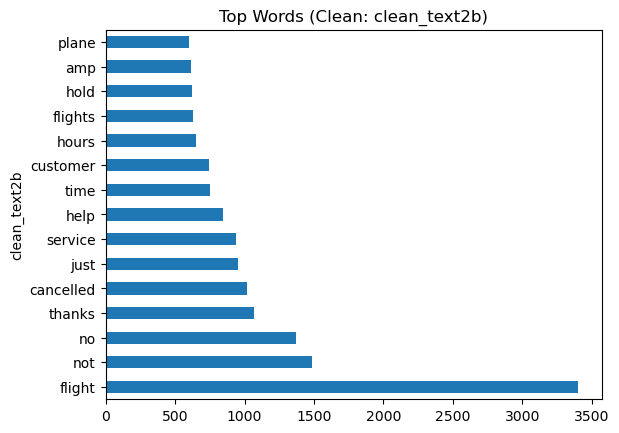

In [140]:
clean_df = df["clean_text2b"].str.split().apply(set).explode().dropna()
clean_df.value_counts().head(15).plot(kind="barh")
plt.title("Top Words (Clean: clean_text2b)")
plt.savefig("docfreq_clean.png")
plt.show()
